# Myopia: Is This Image Blurry or Do I Just Need Glasses?

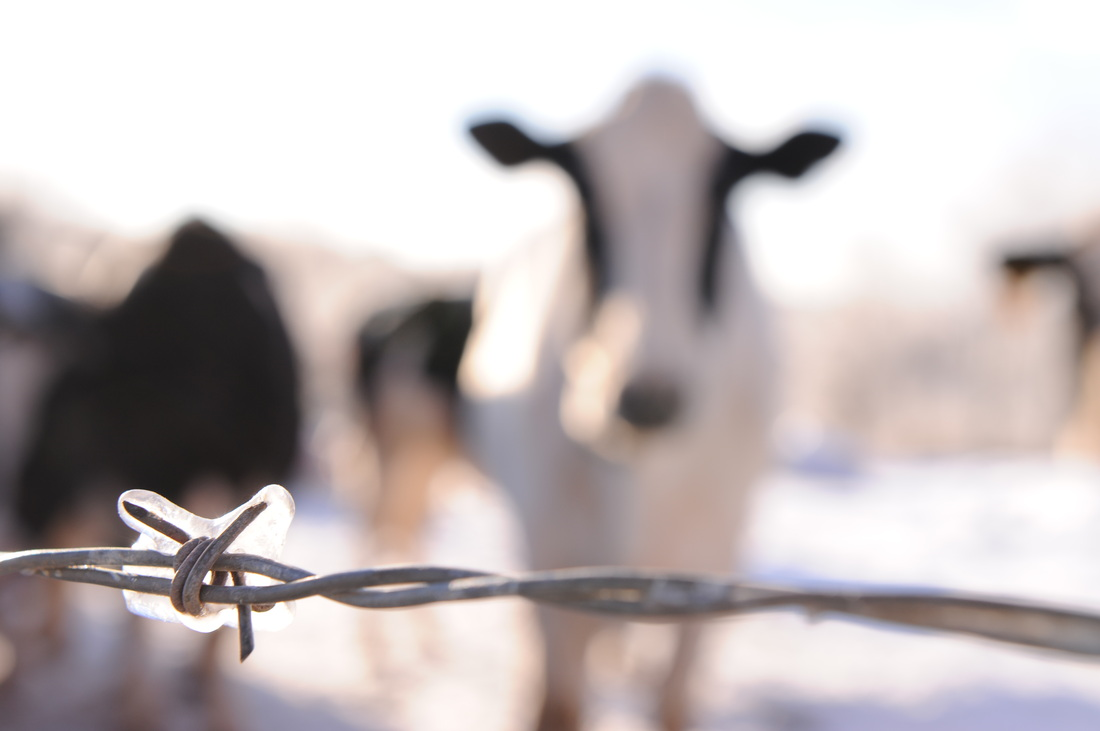

In [1]:
%%bash
cd tensorflow-for-poets-2/tf_files
pwd
ls



/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/notebook/work/tensorflow-for-poets-2/tf_files
bottlenecks
models
retrained_graph.pb
retrained_labels.txt
training_summaries


### Acknowledgments:
* **Tensorflow for Poets** (codelabs.developers.google.com)
* **Siraj Raval** (Youtube: Build a TensorFlow Image Classifier in 5 Min)

### Objective
We are going to use a model trained on the ImageNet Large Visual Recognition Challenge dataset. These models can differentiate between 1,000 different classes, like Dalmatian or dishwasher. It's **NOT** good at classifying flower types. We will start with the generic ImageNet model called **Inception V3** or its smaller cousin **MobileNet** which do not classify flowers. We will use **MobileNet** which is smaller and faster but less accurate than ImageNet. We will use this model as the starting point to re-train a new model which does a good job of classifying flowers.  This technique is called **transfer learning.**

We will use this same model, but retrain it to tell apart a small number of classes based on our own examples.

**What you will learn:**

* How to use Python and TensorFlow to train an image classifier
* How to classify images with your trained classifier

**What you need:**
* **A basic understanding of Linux commands**

In the graphic below, we see three states of the deep neural network.  On the left is the pre-trained network before data has been applied to it. The tan box contains a depiction of a neural network as it is being trained. The green network third from the left represents the network, or "the model", after it has been trained.  At the far right is a depiction of how the model is incorporated in a data flow to performance inference in deployment scenarios.

In the graphic, input data is seen as applied at the top of the network, and the output classifications are seen at the bottom (2 outputs shown here).



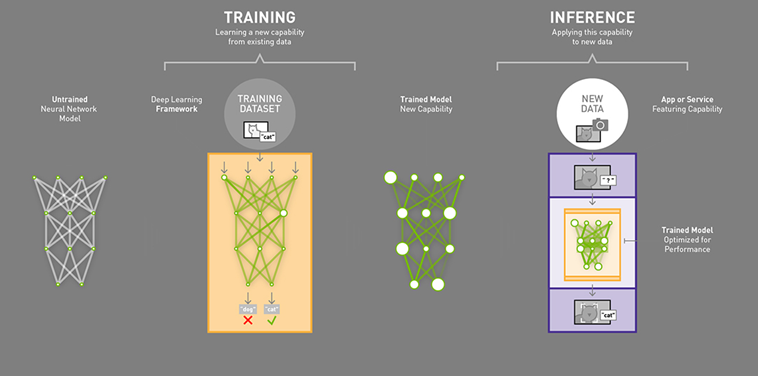


## Transfer learning 
Is allows research teams to develop generic models that do pretty well at a broad class of images. It may take weeks to develop such a model. After it is created it is in the green middle state.  

A developer may wish to leverage all the work subsumed within the model but to tweak it in some way to classify specific type of images, or to have a differnet number of classification outputs.  Additionally, the last layer (the bottom layer shown here) needs to be removed and replaced by a new neural layer with the same number of outputs as we now whish to classify.

The python code called by this notebook handles all this for you.

Operationally, a user can download whatever images they wish to train against. Place them into individual folders named accordin to the desired class. This is a supervised learning task. The user finds images that match their class definition and places them into a labeled folder.  Repeat this for as many classes as desired.

When the retrain.py sript is run, it finds the labeled folders, re-trains the network's newly created final layer only. 

The implicaitons of this are:
* re-training takes much less data
* re-training takes much less time
* re-training builds on the fundamental buidling blocks established by researchers dedicated to finding and publishing state of the art techniques.
* re-training works for related types of domains, for example, a general image classifier can be re-trained to specialize in faces, or banana ripeness, or whatever you decide. 

# Let's start the lab


# 1) Clone the git repository
All the code used in this codelab (except the displayImage.py) is contained in this git repository. Clone the repository and cd into it. This is where we will be working. running the cell will download the code, model, scripts needed to run this lab.

## To save time, run this cell only once!
Clone the tensorflow-for-poets code from googlecodelabs github


In [2]:
%%bash
rm -R tensorflow-for-poets-2
rm *.pyc
git clone https://github.com/googlecodelabs/tensorflow-for-poets-2

pwd
ls

Cloning into 'tensorflow-for-poets-2'...
/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/notebook/work
~
cars.csv
cifar_cnn.py
color_scatter.html
datasets
displayImage.py
DSX_Population
ex_retrain
file.csv
images
__init__.py
layers.py
my_model.pkl
rose-2.jpg
rose-2.jpg.1
tensorflow-for-poets-2
test_image.png
tmp
WA_Fn-UseC_-Telco-Customer-Churn.csv


# 2) Download the Training Images
Before you start any training, you'll need a set of images to teach the model about the new classes you want to recognize. codelabs.developers.google.com created an archive of creative-commons licensed flower photos to use initially. To save time, **Just run this cell once** ,we only need to download the files once! Download the photos (218 MB) by invoking the following two commands:

In [3]:
%%bash
cd tensorflow-for-poets-2/tf_files/
pwd
ls


/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/notebook/work/tensorflow-for-poets-2/tf_files


In [4]:
%%bash
cd tensorflow-for-poets-2/
rm -R  Myopia
git clone https://github.com/zmadscientist/Myopia.git
cd Myopia
tar -zxf sharpblurry.tgz
cd SharpBlurry
mv blurryImages/BL19.jpg .
mv sharpImages/SH1.jpg .
pwd
ls



Cloning into 'Myopia'...
/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/notebook/work/tensorflow-for-poets-2/Myopia/SharpBlurry
BL19.jpg
blurryImages
SH1.jpg
sharpImages


rm: cannot remove ‘Myopia’: No such file or directory


Had you wished to experiment with something other than flowers, you could take the folloing steps (let's assume you want to classify star wars characters from the internet) :
* cd tensorflow-for-poets-2/tf_files/
* mkdir starwars
* cd starwars
* mkdir darth
* mkdir leia
* mkdir C3PO
* Follow these steps by Siraj Raval on Youtube to bulk download 200 images for each starwars character

Youtube (Siraj Raval): Build a TensorFlow Image Classifier in 5 Min
Then classify the iamges in the same way we do for flowers below, replacing 'starwars' for 'flower_photos'

You should now have a copy of the flower photos in your working directory. The fodler represent the labels we are going to predict. Confirm the contents of your working directory by issuing the following command:

In [5]:
%%bash
cd tensorflow-for-poets-2/Myopia/SharpBlurry
pwd
ls


/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/notebook/work/tensorflow-for-poets-2/Myopia/SharpBlurry
BL19.jpg
blurryImages
SH1.jpg
sharpImages


# 3) Start TensorBoard (Optional not working yet)
Before starting the training, launch tensorboard in the background. TensorBoard is a monitoring and inspection tool included with tensorflow. You will use it to monitor the training progress.

In [6]:
%%bash
#cd tensorflow-for-poets-2
#tensorboard --logdir tf_files/training_summaries &

### In Case of Tensorboard error

This command above will fail with the following error if you already have a tensorboard process running:

**ERROR:tensorflow:TensorBoard attempted to bind to port 6006**, but it was already in use

You can kill all existing TensorBoard instances with:

**!pkill -f "tensorboard"**

In [7]:
%%bash
wget http://ipinfo.io/ip -qO -
#pkill -f "tensorboard"
cd tensorflow-for-poets-2
pwd
ls

169.55.204.29
/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/notebook/work/tensorflow-for-poets-2
android
CONTRIBUTING.md
LICENSE
Myopia
README.md
Screenshot.png
scripts
tf_files


# 4) Configure your MobileNet & Run the Training
The retrain script can retrain either **Inception V3** model or a **MobileNet**. In this exercise, we will use a MobileNet. The principal difference is that Inception V3 is optimized for accuracy, while the MobileNets are optimized to be small and efficient, at the cost of some accuracy.

### What are we trying to accomplish here?
We are taking a pretrained model that does at good job at some recognition tasks. But it has not been trained to distinguish particular items such as types of flowers. We are leveraging a technique called **transfer learning** that allows us to take advantage of the lions share of the work involved in training a model on images. The script we are using removes that very last layer of the Inception model - the one that know s how to classify 1000 general purpose images - and it adds a new layer that will be trained instead on the our handful of flower folders.

#### Note:
The original Inception model had never seen or been trained initailly for classify flowers. We will do that now.

### Patience 
This transfer learning training step may take up to two minutes

In [8]:
%%bash
cd tensorflow-for-poets-2
export IMAGE_SIZE=224
export ARCHITECTURE="mobilenet_0.50_${IMAGE_SIZE}"

echo ${IMAGE_SIZE}
echo ${ARCHITECTURE}
start=`date +%s`
python -m scripts.retrain \
  --bottleneck_dir=tf_files/bottlenecks \
  --how_many_training_steps=500 \
  --model_dir=tf_files/models/ \
  --summaries_dir=tf_files/training_summaries/"${ARCHITECTURE}" \
  --output_graph=tf_files/retrained_graph.pb \
  --output_labels=tf_files/retrained_labels.txt \
  --architecture="${ARCHITECTURE}" \
  --image_dir=Myopia/SharpBlurry/
  
end=`date +%s`
runtime=$((end-start))
echo $runtime seconds


224
mobilenet_0.50_224
>> Downloading mobilenet_v1_0.50_224_frozen.tgz 100.1%
Converted 2 variables to const ops.
31 seconds


Traceback (most recent call last):
  File "/usr/local/src/bluemix_jupyter_bundle.v63/notebook/lib/python2.7/logging/__init__.py", line 853, in emit
    msg = self.format(record)
  File "/usr/local/src/bluemix_jupyter_bundle.v63/notebook/lib/python2.7/logging/__init__.py", line 726, in format
    return fmt.format(record)
  File "/usr/local/src/bluemix_jupyter_bundle.v63/notebook/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/local/src/bluemix_jupyter_bundle.v63/notebook/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Logged from file tf_logging.py, line 82
INFO:tensorflow:Looking for images in 'sharpImages'
INFO:tensorflow:Looking for images in 'blurryImages'
2017-10-10 15:11:00.786367: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are availa

# 5) Test an image to see how well it classifies
try a daisy from here: tf_files/flower_photos/daisy/21652746_cc379e0eea_m.jpg  

In [9]:
%%bash
ls tensorflow-for-poets-2/Myopia/SharpBlurry

BL19.jpg
blurryImages
SH1.jpg
sharpImages


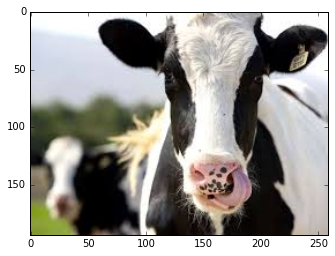

In [10]:
from displayImage import displayImage
displayImage('./tensorflow-for-poets-2/Myopia/SharpBlurry/SH1.jpg')

In [11]:
%%bash
cd tensorflow-for-poets-2
python -m scripts.label_image \
    --graph=tf_files/retrained_graph.pb  \
    --image=Myopia/SharpBlurry/SH1.jpg                                                                                                                                                  2> errlog.txt                                                      


sharpimages 0.995337
blurryimages 0.00466279


# 6) Download a jpg Flower Image from the Internet
try finding a rose jpg on the internet
wget the file to the flower_photos folder

In [12]:
%%bash
cd ~/notebook/work/tensorflow-for-poets-2/
wget http://laphiloselonsylvie2.a.l.f.unblog.fr/files/2014/07/rose-2.jpg
pwd
ls

/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/notebook/work/tensorflow-for-poets-2
android
CONTRIBUTING.md
errlog.txt
LICENSE
Myopia
README.md
rose-2.jpg
Screenshot.png
scripts
tf_files


--2017-10-10 15:11:52--  http://laphiloselonsylvie2.a.l.f.unblog.fr/files/2014/07/rose-2.jpg
Resolving laphiloselonsylvie2.a.l.f.unblog.fr (laphiloselonsylvie2.a.l.f.unblog.fr)... 178.33.42.85
Connecting to laphiloselonsylvie2.a.l.f.unblog.fr (laphiloselonsylvie2.a.l.f.unblog.fr)|178.33.42.85|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137043 (134K) [image/jpeg]
Saving to: ‘rose-2.jpg’

     0K .......... .......... .......... .......... .......... 37%  227K 0s
    50K .......... .......... .......... .......... .......... 74%  450K 0s
   100K .......... .......... .......... ...                  100% 34.7M=0.3s

2017-10-10 15:11:53 (402 KB/s) - ‘rose-2.jpg’ saved [137043/137043]



In [13]:
!pwd
!ls

/gpfs/fs01/user/s37a-6a8375ad9b78b5-6459f7095f24/notebook/work
~		    DSX_Population  rose-2.jpg
cars.csv	    ex_retrain	    rose-2.jpg.1
cifar_cnn.py	    file.csv	    tensorflow-for-poets-2
color_scatter.html  images	    test_image.png
datasets	    __init__.py     tmp
displayImage.py     layers.py	    WA_Fn-UseC_-Telco-Customer-Churn.csv
displayImage.pyc    my_model.pkl


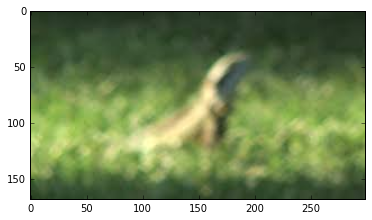

In [14]:
from displayImage import displayImage
#displayImage('./tensorflow-for-poets-2/rose-2.jpg')
displayImage('./tensorflow-for-poets-2/Myopia/SharpBlurry/BL19.jpg')

# 7) Test the web image we downloaded
look in the 
* **~/notebook/work/tensorflow-for-poets-2/tf_files/flower_photos/**

folder

For example, we downloaded an internet image called rose-2.jpg


In [15]:
%%bash
cd tensorflow-for-poets-2
python -m scripts.label_image \
    --graph=tf_files/retrained_graph.pb  \
    --image=Myopia/SharpBlurry/BL19.jpg                                                                                                                     2> errorlog.txt
#    --image=rose-2.jpg                                                                                                                                      2> errorlog.txt                
    

blurryimages 0.999967
sharpimages 3.33172e-05


# Conclusion
We downloaded a model from github.com/googlecodelabs/ that is trained for general images. It is not trained to classify the flower types we had in mind. We retrained the model with a realtively small number of jpgs for each new class. The way the images were labeled in this example was by the folder name for each class.

The retrain script identifies the names and locations of out labeled classs via the folder names, and then freezes the lower detaield layers of the model, adds a new layer to reflect the number of new classes we care about, and retrains the model.

We then tested the model by downloading an image from the internet related to one of our newly trained classes, and observed that the random image was classified pretty accurately.